In [1]:
import warnings
warnings.filterwarnings("ignore")
#
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random
import scipy.sparse as sp
import scipy
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from itertools import chain, combinations
import pandas as pd
import matplotlib.cm as cm
from scipy.stats import pearsonr,spearmanr

In [2]:
SEED = 2021
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DATA_FOLDER = 'data/'
PLOT_FOLDER = 'plots/'
RERUN_EXPERIMENT = False #if False, logged results will be loaded

In [4]:
# motif utils

def make_motif_names(info):
    initials = info[::2]
    counts = info[1::2]
    return [a for b in [[init+str(i) for i in range(count)] \
                        for init,count in zip(initials,counts)] for a in b]

def edgelist_to_nx(edgelists):
    motifs = []
    for edgelist in edgelists:
        tmp = nx.empty_graph()
        for (n1,n2) in edgelist:
            tmp.add_edge(n1,n2)
        motifs.append(tmp)
    return motifs

def subgraph_status(big,small):
    matches = [e in big.edges for e in small.edges]
    if all(matches):
        return 'OK'
    elif all(np.logical_not(matches)):
        return 'KO'
    else:
        return '??'
    
def contains_motif(graph,motif):
    occurring = [e in graph.edges for e in motif.edges]
    return 'completely occurring' if all(occurring) else 'not occurring' \
            if all(np.logical_not(occurring)) else 'partially occurring'

In [5]:
# masking

def mask_motif_set(graph,motifs,mask_mode):
    edges = set([a for b in [[tuple(sorted(e)) for e in m.edges] for m in motifs] for a in b])
    if mask_mode == 'remove':
        return remove_motifs(graph,edges)
    if mask_mode == 'toggle':
        return toggle_motifs(graph,edges)
    if mask_mode == 'blur':
        return blur_motifs(graph,edges)
    else:
        print('unknown mask mode')

def remove_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        if tmp.has_edge(n1,n2):
            tmp.remove_edge(n1,n2)
    return tmp

def toggle_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        if tmp.has_edge(n1,n2):
            tmp.remove_edge(n1,n2)
        else:
            tmp.add_edge(n1,n2)
    return tmp

def blur_motifs(graph,edges):
    tmp = graph.copy()
    for (n1,n2) in edges:
        tmp.add_edge(n1,n2)
        tmp[n1][n2]['weight'] = avg_graph_density
    return tmp

In [6]:
# classification

def sp_matrix_to_sp_tensor(M):
    if not isinstance(M, sp.csr.csr_matrix):
        M = M.tocsr()
    row, col = M.nonzero()
    batch = np.zeros(row.shape[0])
    X = tf.SparseTensor(np.mat([batch, row, col]).T, M.data, (1,) + M.shape)
    X = tf.cast(X, tf.float32)
    return X

def classify(model,masked_graph,nodes_per_graph):  
    sparse_adj = sp_matrix_to_sp_tensor(nx.to_scipy_sparse_matrix(masked_graph))
    fake_eye = tf.SparseTensor(np.mat([np.zeros(nodes_per_graph), np.arange(nodes_per_graph), \
                np.arange(nodes_per_graph)]).T, np.ones(nodes_per_graph, dtype=np.float32), \
                            (1,nodes_per_graph,nodes_per_graph))
    raw = model([sparse_adj,fake_eye]).numpy()[0]
    c1_prob = scipy.special.softmax(raw)[1]
    return c1_prob

def batch_classify(model,graphs,nodes_per_graph):
    sparse_adj = tf.sparse.concat(0,[sp_matrix_to_sp_tensor(nx.to_scipy_sparse_matrix(g)) for g in graphs])
    fake_eye = tf.SparseTensor(np.mat([np.zeros(nodes_per_graph), np.arange(nodes_per_graph), \
                np.arange(nodes_per_graph)]).T, np.ones(nodes_per_graph, dtype=np.float32), \
                            (1,nodes_per_graph,nodes_per_graph))
    all_eye = tf.sparse.concat(0,[fake_eye for _ in graphs])
    raw = model([sparse_adj,fake_eye]).numpy()
    c1_prob = np.array([scipy.special.softmax(line)[1] for line in raw])
    return c1_prob

In [7]:
# lattice

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def pascaline(n):
    "pascaline(5) -> [1, 4, 6, 4, 1]"
    n -= 1
    line = [1]
    for k in range(max(n,0)):             
        line.append(line[k]*(n-k)//(k+1))             
    return line

def build_lattice(bbox,datapoint,nodes_per_graph,motifs,mask_mode):
    lattice_nodes = {}
    for team in powerset(enumerate(motifs)):
        indxs = tuple(indx for (indx,m) in team)
        motifs_team = [m for (indx,m) in team]
        masked_graph = mask_motif_set(datapoint,motifs_team,mask_mode)
        outp = classify(bbox,masked_graph,nodes_per_graph)
        local_dict = {'motifs':motifs_team,'masked':masked_graph,'outp':outp}
        lattice_nodes[indxs] = local_dict
    return lattice_nodes

def batch_build_lattice(bbox,graphs,nodes_per_graph,motifs,mask_mode):
    lattice_nodes = {}
    tmp_len = 0
    for team in powerset(enumerate(motifs)):
        if len(team)>tmp_len:
            print(len(team),end=' ')
            tmp_len+=1
        indxs = tuple(indx for (indx,m) in team)
        motifs_team = [m for (indx,m) in team]
        masked_graphs = [mask_motif_set(g,motifs_team,mask_mode) for g in graphs]
        outp = batch_classify(bbox,masked_graphs,nodes_per_graph)
        lattice_nodes[indxs] = outp
    print()
    return lattice_nodes

In [8]:
# shapley

def get_shapley_values(lattice,motifs):
    shap_dict = {}
    for indx,motif in enumerate(motifs):
        mnope = powerset([x for x in range(len(motifs)) if x!=indx])
        mwith = [tuple(sorted([*team,indx])) for team in mnope]
        raw_shapley = [lattice[mno]['outp']-lattice[myes]['outp'] for mno,myes in list(zip(mnope,mwith))]
        pascal = pascaline(len(motifs))
        coef = [1./len(motifs)/pascal[len(key)] for key in mnope]
        shapley = np.dot(coef,raw_shapley)
        shap_dict[indx] = shapley
    return shap_dict

def batch_get_shapley_values(lattice,motifs):
    shap_dict = {}
    for indx,motif in enumerate(motifs):
        mnope = powerset([x for x in range(len(motifs)) if x!=indx])
        mwith = [tuple(sorted([*team,indx])) for team in mnope]
        diff = [lattice[mno]-lattice[myes] for mno,myes in list(zip(mnope,mwith))]
        pascal = pascaline(len(motifs))
        coef = [1./len(motifs)/pascal[len(key)] for key in mnope]
        shap_weighted_margins = [c*sh for c,sh in zip(coef,diff)]
        shap_values = np.sum(np.array(shap_weighted_margins),axis=0)
        shap_dict[indx] = shap_values
    return shap_dict

In [9]:
# correlation

def get_correlation_data(graphs,motifs,global_shaps_remove,global_shaps_blur,global_shaps_toggle):
    forced_motifs = []
    for indx,g in enumerate(graphs):
        forced_motifs.append([subgraph_status(g,m) for m in motifs])
    forced_motifs = np.array(forced_motifs)
    forced_motifs_val = np.zeros(forced_motifs.shape)
    forced_motifs_val += (forced_motifs == 'OK')
    forced_motifs_val -= (forced_motifs == 'KO')
    #
    target = [-1]*graphs_per_class + [1]*graphs_per_class
    prob = np.array([[0,.2,.4,.6,.8,1]]*(graphs_per_class*2))
    motif_class = np.array([[-1,1,-1,1,-1,1]]*(graphs_per_class*2))
    expected_shap = (forced_motifs_val*prob*motif_class)
    #
    shap_table_remove = np.stack([global_shaps_remove[mi] for mi in range(6)]).T
    shap_table_blur = np.stack([global_shaps_blur[mi] for mi in range(6)]).T
    shap_table_toggle = np.stack([global_shaps_toggle[mi] for mi in range(6)]).T
    tables = dict(zip(['remove', 'blur', 'toggle'],[shap_table_remove,shap_table_blur,shap_table_toggle]))
    #
    return expected_shap,tables

In [10]:
# plotting

def violin_plot(ax, shaps, widths=0.2):
    nmotifs = len(shaps)
    labels = []
    max_shap = max([abs(a) for b in list(shaps.values()) for a in b])
    positions = range(6)
    c0_data = [shaps[i][:100] for i in list(shaps.keys())]
    return ax.violinplot(c0_data, list(shaps.keys()), widths=widths)

def plot_correlation(expected_shap,tables):  
    gshap_modes = tables.keys()
    fig, axs = plt.subplots(3,1,sharex=True, figsize=(4.5, 4.5))
    plt.tight_layout(pad=0.1)
    for i, mode in enumerate(gshap_modes):
        cor = spearmanr(tables[mode].flatten(), expected_shap.flatten())
        ax = axs.flatten()[i]
        df = pd.DataFrame({"expected": expected_shap.flatten(), 
                           "graphshap": tables[mode].flatten()}).set_index('expected')
        violin_data = {}
        for k, g in df.groupby('expected'):
            violin_data[k] = g['graphshap'].values
        v = violin_plot(ax, violin_data, widths=0.15)
        v['cmaxes'].set_linewidth(0.5)
        v['cmins'].set_linewidth(0.5)
        v['cbars'].set_linewidth(0.5)
        for b in v:
            pass
        [i.set_linewidth(0.5) for i in ax.spines.values()]
        ax.set_ylim(-0.32, 0.32)
        ax.text(-1.1, 0.2, f"{mode.replace('blur','average')} (Spearman: {cor.correlation:.2f})")
        if i==2:
            ax.set_xlabel('Expected explanation score')
        if i==1:
            ax.set_ylabel('Distribution of explanation scores')
    fig.suptitle('')

In [11]:
EXP_NAME = 'exp62'

In [12]:
graphs_0 = pickle.load(open(DATA_FOLDER+'synth_'+EXP_NAME+'_0','rb'))
graphs_1 = pickle.load(open(DATA_FOLDER+'synth_'+EXP_NAME+'_1','rb'))
graphs = graphs_0+graphs_1
assert len(set([len(g) for g in graphs])) == 1
nodes_per_graph = len(graphs[0])
assert len(graphs_0)==len(graphs_1)
graphs_per_class = len(graphs_0)
avg_graph_density = np.mean([len(g.edges)/(nodes_per_graph*nodes_per_graph) for g in graphs])
labels = [0]*len(graphs_0)+[1]*len(graphs_1)
#
injected = pickle.load(open(DATA_FOLDER+'injected_'+EXP_NAME,'rb'))
motif_names = make_motif_names(['I',len(injected)])
#
bbox = tf.keras.models.load_model(DATA_FOLDER+'gcnn_'+'synth_'+EXP_NAME)
print('bbox:',sum((batch_classify(bbox,graphs,nodes_per_graph)>.5)==labels),'over',len(labels))

bbox: 191 over 200


In [13]:
if RERUN_EXPERIMENT:
    global_lattice_remove = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='remove')
    global_shaps_remove = batch_get_shapley_values(global_lattice_remove,injected)
    global_lattice_toggle = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='toggle')
    global_shaps_toggle = batch_get_shapley_values(global_lattice_toggle,injected)
    global_lattice_blur = batch_build_lattice(bbox,graphs,nodes_per_graph,injected,mask_mode='blur')
    global_shaps_blur = batch_get_shapley_values(global_lattice_blur,injected)
    global_dict = {'global_shaps_remove':global_shaps_remove,
                  'global_shaps_toggle':global_shaps_toggle,
                  'global_shaps_blur':global_shaps_blur}
    pickle.dump(global_dict,open(DATA_FOLDER+'shaps_exp62','wb'))  

In [14]:
global_dict = pickle.load(open(DATA_FOLDER+'shaps_exp62','rb'))
global_shaps_remove = global_dict['global_shaps_remove']
global_shaps_toggle = global_dict['global_shaps_toggle']
global_shaps_blur = global_dict['global_shaps_blur']

In [15]:
table1 = np.array([[prob,np.mean(global_shaps_remove[indx])] for indx,prob in enumerate([0,.2,.4,.6,.8,1])])
pd.DataFrame(table1.T,index=['Perturbation_probability','Average_explanation_score'],\
             columns=['M'+str(i) for i in range(6)])

,M0,M1,M2,M3,M4,M5
Perturbation_probability,0.000000,0.200000,0.400000,0.600000,0.800000,1.000000
Average_explanation_score,-0.005767,0.014019,-0.031241,0.066047,-0.067394,0.095368


In [16]:
expected_shap,tables = get_correlation_data(graphs,injected,\
                            global_shaps_remove,global_shaps_blur,global_shaps_toggle)

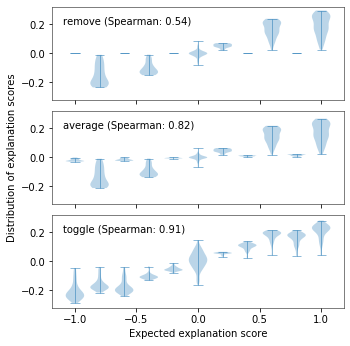

In [17]:
plot_correlation(expected_shap,tables)
plt.savefig(PLOT_FOLDER+'fig5.pdf')